![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import statistics as st
import re
import datetime
import math 


import re, string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [4]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [6]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [8]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [9]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [10]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [11]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [13]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
42617,id_10962,London,NaN,10972.0,NaN,5.0,"[['Lovely', 'Quick cheap lunch'], ['08/08/2017...",/Restaurant_Review-g186338-d5122696-Reviews-An...,d5122696,1,4.0
3382,id_3382,Rome,NaN,4802.0,NaN,31.0,"[['Nice place.....'], ['04/23/2016']]",/Restaurant_Review-g187791-d5814255-Reviews-So...,d5814255,0,0.0
4845,id_4845,Paris,"['French', 'Bar', 'Pub']",11591.0,$$ - $$$,73.0,"[['Amazing dinner with great service', 'Late n...",/Restaurant_Review-g187147-d3507196-Reviews-Un...,d3507196,0,0.0
10428,id_1619,Madrid,"['Italian', 'Pizza']",1621.0,$$ - $$$,107.0,"[['Amazing exoerience'], ['09/12/2015']]",/Restaurant_Review-g187514-d3218566-Reviews-Pi...,d3218566,1,4.5
47572,id_15381,London,NaN,15393.0,NaN,6.0,"[['Total Chaos', 'Quick bite before long drive...",/Restaurant_Review-g186338-d10501129-Reviews-B...,d10501129,1,3.0


In [14]:
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

### 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

Какие признаки можно считать категориальными?

Для кодирования категориальных признаков есть множество подходов:
* Label Encoding
* One-Hot Encoding
* Target Encoding
* Hashing

Выбор кодирования зависит от признака и выбраной модели.
Не будем сейчас сильно погружаться в эту тематику, давайте посмотрим лучше пример с One-Hot Encoding:
![](https://i.imgur.com/mtimFxh.png)

In [15]:
# для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
#data = pd.get_dummies(data, columns=[ 'City',], dummy_na=True)

### City

In [16]:


#добавляем колонку кол-во ресторанов в каждом городе

cities = data.City.value_counts()
data.loc[:, 'number_of_rests_in_city'] = 0

for i in range(0, len(data.City)):
    data.number_of_rests_in_city[i] = cities[data.City[i]]

    
# добавить колонку кол-во ресторанов минус рейтинг в городе
data['Rank_in_data'] = data.number_of_rests_in_city-data.Ranking

# добавляем дамми переменные разных городов
#data = pd.get_dummies(data, columns=[ 'City',], dummy_na=True)
# добавляем дамми переменные разных городов
City_names = data.City.str.get_dummies()
data = data.join(City_names)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [17]:
data

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,...,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,...,0,0,0,1,0,0,0,0,0,0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,...,0,0,0,0,0,0,0,0,0,0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,...,0,0,0,0,0,0,0,0,0,0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,...,0,0,0,0,0,0,0,0,0,0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,id_499,Milan,"['Italian', 'Vegetarian Friendly', 'Vegan Opti...",500.0,$$ - $$$,79.0,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414,1,...,0,0,0,0,0,0,0,0,0,0
49996,id_6340,Paris,"['French', 'American', 'Bar', 'European', 'Veg...",6341.0,$$ - $$$,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036,1,...,0,0,0,1,0,0,0,0,0,0
49997,id_1649,Stockholm,"['Japanese', 'Sushi']",1652.0,NaN,4.0,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615,1,...,0,0,0,0,0,0,1,0,0,0
49998,id_640,Warsaw,"['Polish', 'European', 'Eastern European', 'Ce...",641.0,$$ - $$$,70.0,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838,1,...,0,0,0,0,0,0,0,0,1,0


In [18]:
data.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,...,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,...,0,0,0,1,0,0,0,0,0,0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,...,0,0,0,0,0,0,0,0,0,0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,...,0,0,0,0,0,0,0,0,0,0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,...,0,0,0,0,0,0,0,0,0,0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,...,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich
37467,id_1654,Barcelona,"['Mediterranean', 'European', 'Spanish']",1655.0,$$ - $$$,129.0,[['Fantastic service for English-only speakin....,/Restaurant_Review-g187497-d6022569-Reviews-To...,d6022569,1,...,0,0,0,0,0,0,0,0,0,0
29999,id_14798,London,NaN,14809.0,NaN,2.0,"[['Good service and food choice', 'A nice litt...",/Restaurant_Review-g186338-d6621416-Reviews-So...,d6621416,1,...,0,0,0,0,0,0,0,0,0,0
1779,id_1779,London,"['Cafe', 'Healthy', 'Gluten Free Options']",8897.0,$,4.0,"[['yumy scrummy juices and fabulous snacks', '...",/Restaurant_Review-g186338-d10179503-Reviews-T...,d10179503,0,...,0,0,0,0,0,0,0,0,0,0
2217,id_2217,Madrid,['Pizza'],4203.0,NaN,NaN,"[[], []]",/Restaurant_Review-g187514-d5767984-Reviews-Te...,d5767984,0,...,0,0,0,0,0,0,0,0,0,0
20159,id_9260,London,NaN,9269.0,NaN,NaN,"[['Great ""Brunch"" with fizz'], ['05/19/2016']]",/Restaurant_Review-g186338-d10335864-Reviews-C...,d10335864,1,...,0,0,0,0,0,0,0,0,0,0


### Ranking

In [20]:
data.Ranking = data.Ranking.astype(int)

### Price Range

#### Возьмем следующий признак "Price Range".

In [21]:
data['Price Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

По описанию 'Price Range' это - Цены в ресторане.  
Их можно поставить по возрастанию (значит это не категориальный признак). А это значит, что их можно заменить последовательными числами, например 1,2,3  
*Попробуйте сделать обработку этого признака уже самостоятельно!*

In [22]:
# Ваша обработка 'Price Range'
data['Price Range'].describe()
# меняем символьное обозначение на буквенное
data['Price Range'] = data['Price Range'].replace('$$$$', 3)
data['Price Range'] = data['Price Range'].replace('$$ - $$$', 2)
data['Price Range'] = data['Price Range'].replace('$', 1)

data['Price Range'].value_counts(dropna=False)

# заполняем пропуски рандомно, сохраняя исходное соотношение между значениями
import random

mylist = [3, 1, 2]

w_1 = data['Price Range'][data['Price Range'] == 3].count()/len(data['Price Range'])
w_2 = data['Price Range'][data['Price Range'] == 1].count()/len(data['Price Range'])
w_3 = data['Price Range'][data['Price Range'] == 2].count()/len(data['Price Range'])


random_prices = random.choices(mylist, weights = [w_1, w_2, w_3], k = data['Price Range'].isnull().sum())

j=0
for i in range(len(data['Price Range'])):
    if pd.isna(data['Price Range'][i]) == True:
        data['Price Range'][i]=random_prices[j]
        j+=1
        
data['Price Range'].value_counts(dropna=False)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2.0    35236
1.0    12017
3.0     2747
Name: Price Range, dtype: int64

> Для некоторых алгоритмов МЛ даже для не категориальных признаков можно применить One-Hot Encoding, и это может улучшить качество модели. Пробуйте разные подходы к кодированию признака - никто не знает заранее, что может взлететь.

### Обработать другие признаки вы должны самостоятельно!
Для обработки других признаков вам возможно придется даже написать свою функцию, а может даже и не одну, но в этом и есть ваша практика в этом модуле!     
Следуя подсказкам в модуле вы сможете более подробно узнать, как сделать эти приобразования.

### Number of Reviews

In [23]:
data = data.fillna(0)
data['Number of Reviews']=data['Number of Reviews'].astype(int)


### Reviews

In [24]:
# выделяем из колонки Reviews даты и записываем их в отдельные колонки
dates = []
for line in data.Reviews:
    dates.append(re.findall(r'\d{2}/\d{2}/\d{4}', str(line)))

date_1 = []
date_2 = []
for value in dates:
    if value == []:
        date_1.append(datetime.date.today())
        date_2.append(datetime.date.today())
    elif len(value) == 1:
        date_1.append(datetime.datetime.strptime(value[0], '%m/%d/%Y').date())
        date_2.append(datetime.datetime.strptime(value[0], '%m/%d/%Y').date())
    else:
        date_1.append(datetime.datetime.strptime(value[0], '%m/%d/%Y').date())
        date_2.append(datetime.datetime.strptime(value[1], '%m/%d/%Y').date())

data['date_1'] = date_1
data['date_2'] = date_2

# добавляем колонку с разницей дат
time_delta = data['date_1']-data['date_2']
data['time_delta'] = time_delta.dt.days

In [25]:
#получаем список комментрариев отдельно от дат, чистим комментарии, оставляем тлько значимые слова

import re, string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

sw = stopwords.words('english')

#The function
def clean_text(text):
    text = text.lower()
    text = re.sub('@', '', text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r"[^a-zA-Z ]+", "", text)
    
    #Tokenize the data
    text = nltk.word_tokenize(text)
    #Remove stopwords
    text = [w for w in text if w not in sw]
    return text


# comments = []
# for line in df.Reviews:
#     my_string = line.split("], [")[0]
#     comments.append(clean_text(my_string))
# comments

#df.Reviews = df.Reviews.apply(lambda x: df.Reviews[i].split("], [")[0]  )
data.Reviews = list(map(lambda  x: str(x).split("], [")[0],data.Reviews))
data.Reviews = data.Reviews.apply(lambda x: clean_text(x))



In [26]:
# #смотрим частоту повторения слов  
# all_words=[]        
# for i in range(len(df)):
#     all_words = all_words + df.Reviews[i]
# #Get word frequency        
# nlp_words = nltk.FreqDist(all_words)
# #plot1 = nlp_words.plot(20, color='salmon', title='Word Frequency')

# # 100 самых частых слов
# i=0
# for item in nlp_words:
#     i+=1
#     print(item)
#     if i==100:
#         break

In [27]:
# отбираем вручную положительные слова
positive_words = ['good', 'great', 'nice', 'best', 'excellent', 'delicious', 'friendly', 'lovely', 'amazing',
                  'tasty', 'fantastic', 'perfect', 'wonderful', 'cozy', 'pleasant', 'love', 'super', 'surprise', 
                  'beautiful']

#  доблвяем колонку о количестве позитивных слов в комментарии
data.loc[:, 'positive_words'] = 0
for i in range(0, len(data.Reviews)):
    k = 0
    for word in data.Reviews[i]:
        if word in positive_words:
            k += 1
    data.positive_words[i] = k

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


### Cuisine_Style

In [28]:
# удаляем лишние символы
# Кухни, которые встречаются меньше пяти раз отноми к категории other
data['Cuisine Style'] = data['Cuisine Style'].str.replace('[', '')
data['Cuisine Style'] = data['Cuisine Style'].str.replace(']', '')
data['Cuisine Style'] = data['Cuisine Style'].str.replace("' ", '')
data['Cuisine Style'] = data['Cuisine Style'].str.replace("'", '')

# заполняем пропуски значением other_cuisine
for i in range(len(data['Cuisine Style'])):
    if pd.isna(data['Cuisine Style'][i]) == True:
        data['Cuisine Style'][i] = 'other_cuisine'



/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [29]:
data['Cuisine Style']

0                                                 Bar, Pub
1        European, Scandinavian, Gluten Free Options, V...
2                                      Vegetarian Friendly
3        Italian, Mediterranean, European, Vegetarian F...
4        Italian, Mediterranean, European, Seafood, Veg...
                               ...                        
49995    Italian, Vegetarian Friendly, Vegan Options, G...
49996    French, American, Bar, European, Vegetarian Fr...
49997                                      Japanese, Sushi
49998    Polish, European, Eastern European, Central Eu...
49999                                              Spanish
Name: Cuisine Style, Length: 50000, dtype: object

In [30]:
# добавляем дамми переменные разных кухонь
cuisine_types = data['Cuisine Style'].str.get_dummies(sep=',')
data = data.join(cuisine_types)
data.columns


Index(['Restaurant_id', 'City', 'Cuisine Style', 'Ranking', 'Price Range',
       'Number of Reviews', 'Reviews', 'URL_TA', 'ID_TA', 'sample',
       ...
       'Tibetan', 'Turkish', 'Ukrainian', 'Uzbek', 'Vegan Options',
       'Vegetarian Friendly', 'Venezuelan', 'Vietnamese', 'Wine Bar',
       'other_cuisine'],
      dtype='object', length=281)

In [31]:
data.columns[:100]

Index(['Restaurant_id', 'City', 'Cuisine Style', 'Ranking', 'Price Range',
       'Number of Reviews', 'Reviews', 'URL_TA', 'ID_TA', 'sample', 'Rating',
       'number_of_rests_in_city', 'Rank_in_data', 'Amsterdam', 'Athens',
       'Barcelona', 'Berlin', 'Bratislava', 'Brussels', 'Budapest',
       'Copenhagen', 'Dublin', 'Edinburgh', 'Geneva', 'Hamburg', 'Helsinki',
       'Krakow', 'Lisbon', 'Ljubljana', 'London', 'Luxembourg', 'Lyon',
       'Madrid', 'Milan', 'Munich', 'Oporto', 'Oslo', 'Paris', 'Prague',
       'Rome', 'Stockholm', 'Vienna', 'Warsaw', 'Zurich', 'date_1', 'date_2',
       'time_delta', 'positive_words', ' Afghani', ' African', ' Albanian',
       ' American', ' Arabic', ' Argentinean', ' Armenian', ' Asian',
       ' Australian', ' Austrian', ' Azerbaijani', ' Balti', ' Bangladeshi',
       ' Bar', ' Barbecue', ' Belgian', ' Brazilian', ' Brew Pub', ' British',
       ' Burmese', ' Cafe', ' Cajun & Creole', ' Cambodian', ' Canadian',
       ' Caribbean', ' Caucasi

In [32]:
data

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,...,Tibetan,Turkish,Ukrainian,Uzbek,Vegan Options,Vegetarian Friendly,Venezuelan,Vietnamese,Wine Bar,other_cuisine
0,id_0,Paris,"Bar, Pub",12963,2.0,4,[],/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,...,0,0,0,0,0,0,0,0,0,0
1,id_1,Helsinki,"European, Scandinavian, Gluten Free Options, V...",106,2.0,97,"[good, reviews, fine, dining, hakaniemi]",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,...,0,0,0,0,0,0,0,0,0,0
2,id_2,Edinburgh,Vegetarian Friendly,810,2.0,28,"[better, links, ivy, black]",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,...,0,0,0,0,0,1,0,0,0,0
3,id_3,London,"Italian, Mediterranean, European, Vegetarian F...",1669,3.0,202,"[exquisite, delicious, authentic]",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,...,0,0,0,0,0,0,0,0,0,0
4,id_4,Bratislava,"Italian, Mediterranean, European, Seafood, Veg...",37,3.0,162,"[always, best, bratislava, good, pricey]",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,id_499,Milan,"Italian, Vegetarian Friendly, Vegan Options, G...",500,2.0,79,"[real, italian, experience, wonderful, food, w...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414,1,...,0,0,0,0,0,0,0,0,0,0
49996,id_6340,Paris,"French, American, Bar, European, Vegetarian Fr...",6341,2.0,542,"[parisian, atmosphere, bit, pricey, interestin...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036,1,...,0,0,0,0,0,0,0,0,0,0
49997,id_1649,Stockholm,"Japanese, Sushi",1652,2.0,4,"[good, swedish, standards, hidden, jewel, midd...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615,1,...,0,0,0,0,0,0,0,0,0,0
49998,id_640,Warsaw,"Polish, European, Eastern European, Central Eu...",641,2.0,70,"[underground, restaurant, oldest, restaurant, ...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838,1,...,0,0,0,0,0,0,0,0,0,0


In [33]:
# Кухни, которые встречаются меньше 3000 раз отноми к категории other_cuisine
columns = []

for column in data.columns[50:]:

    if data[column].sum() < 3000:
        data.other_cuisine = data.other_cuisine + data[column]
        columns.append(column)

data = data.drop(data[columns], axis=1)

In [34]:
data.columns[:50]

Index(['Restaurant_id', 'City', 'Cuisine Style', 'Ranking', 'Price Range',
       'Number of Reviews', 'Reviews', 'URL_TA', 'ID_TA', 'sample', 'Rating',
       'number_of_rests_in_city', 'Rank_in_data', 'Amsterdam', 'Athens',
       'Barcelona', 'Berlin', 'Bratislava', 'Brussels', 'Budapest',
       'Copenhagen', 'Dublin', 'Edinburgh', 'Geneva', 'Hamburg', 'Helsinki',
       'Krakow', 'Lisbon', 'Ljubljana', 'London', 'Luxembourg', 'Lyon',
       'Madrid', 'Milan', 'Munich', 'Oporto', 'Oslo', 'Paris', 'Prague',
       'Rome', 'Stockholm', 'Vienna', 'Warsaw', 'Zurich', 'date_1', 'date_2',
       'time_delta', 'positive_words', ' Afghani', ' African'],
      dtype='object')

In [35]:


# добавляем новый признак - количество кухонь в ресторане
data.loc[:, 'number_of_cuisines'] = 0

cuisine_quantity = []
for value in data['Cuisine Style']:

    cuisine_quantity.append(len(value.split(', ')))

data.number_of_cuisines = data.number_of_cuisines + cuisine_quantity

# среднее количество кухонь в одном ресторане
cuisines_average = (cuisine_types.sum().sum() +
                    data['Cuisine Style'].isnull().sum())/len(cuisine_types)



# добавляем новый признак - количество кухонь в ресторане выше среднего
data.loc[:, 'number_of_cuisines_above_average'] = 0

above_average = []
for value in data.number_of_cuisines:
    if value > cuisines_average:
        above_average.append(1)
    else:
        above_average.append(0)

data.number_of_cuisines_above_average = data.number_of_cuisines_above_average + above_average

In [36]:
data

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,...,European,Gluten Free Options,Mediterranean,Vegan Options,Vegetarian Friendly,French,Italian,other_cuisine,number_of_cuisines,number_of_cuisines_above_average
0,id_0,Paris,"Bar, Pub",12963,2.0,4,[],/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,...,0,0,0,0,0,0,0,2,2,0
1,id_1,Helsinki,"European, Scandinavian, Gluten Free Options, V...",106,2.0,97,"[good, reviews, fine, dining, hakaniemi]",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,...,0,1,0,1,1,0,0,2,5,1
2,id_2,Edinburgh,Vegetarian Friendly,810,2.0,28,"[better, links, ivy, black]",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,...,0,0,0,0,0,0,0,1,1,0
3,id_3,London,"Italian, Mediterranean, European, Vegetarian F...",1669,3.0,202,"[exquisite, delicious, authentic]",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,...,1,1,1,0,1,0,1,0,5,1
4,id_4,Bratislava,"Italian, Mediterranean, European, Seafood, Veg...",37,3.0,162,"[always, best, bratislava, good, pricey]",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,...,1,1,1,0,1,0,1,1,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,id_499,Milan,"Italian, Vegetarian Friendly, Vegan Options, G...",500,2.0,79,"[real, italian, experience, wonderful, food, w...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414,1,...,0,1,0,1,1,0,1,0,4,1
49996,id_6340,Paris,"French, American, Bar, European, Vegetarian Fr...",6341,2.0,542,"[parisian, atmosphere, bit, pricey, interestin...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036,1,...,1,0,0,0,1,1,0,2,5,1
49997,id_1649,Stockholm,"Japanese, Sushi",1652,2.0,4,"[good, swedish, standards, hidden, jewel, midd...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615,1,...,0,0,0,0,0,0,0,2,2,0
49998,id_640,Warsaw,"Polish, European, Eastern European, Central Eu...",641,2.0,70,"[underground, restaurant, oldest, restaurant, ...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838,1,...,1,0,0,0,1,0,0,3,5,1


In [37]:
data.columns[:50]

Index(['Restaurant_id', 'City', 'Cuisine Style', 'Ranking', 'Price Range',
       'Number of Reviews', 'Reviews', 'URL_TA', 'ID_TA', 'sample', 'Rating',
       'number_of_rests_in_city', 'Rank_in_data', 'Amsterdam', 'Athens',
       'Barcelona', 'Berlin', 'Bratislava', 'Brussels', 'Budapest',
       'Copenhagen', 'Dublin', 'Edinburgh', 'Geneva', 'Hamburg', 'Helsinki',
       'Krakow', 'Lisbon', 'Ljubljana', 'London', 'Luxembourg', 'Lyon',
       'Madrid', 'Milan', 'Munich', 'Oporto', 'Oslo', 'Paris', 'Prague',
       'Rome', 'Stockholm', 'Vienna', 'Warsaw', 'Zurich', 'date_1', 'date_2',
       'time_delta', 'positive_words', ' Afghani', ' African'],
      dtype='object')

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 60 columns):
Restaurant_id                       50000 non-null object
City                                50000 non-null object
Cuisine Style                       50000 non-null object
Ranking                             50000 non-null int64
Price Range                         50000 non-null float64
Number of Reviews                   50000 non-null int64
Reviews                             50000 non-null object
URL_TA                              50000 non-null object
ID_TA                               50000 non-null object
sample                              50000 non-null int64
Rating                              50000 non-null float64
number_of_rests_in_city             50000 non-null int64
Rank_in_data                        50000 non-null float64
Amsterdam                           50000 non-null int64
Athens                              50000 non-null int64
Barcelona               

![](https://cs10.pikabu.ru/post_img/2018/09/06/11/1536261023140110012.jpg)

# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.
![](https://miro.medium.com/max/2598/1*RXdMb7Uk6mGqWqPguHULaQ.png)

### Посмотрим распределение признака

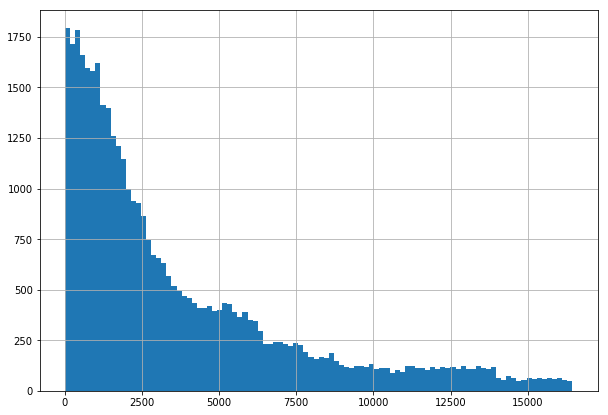

In [39]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

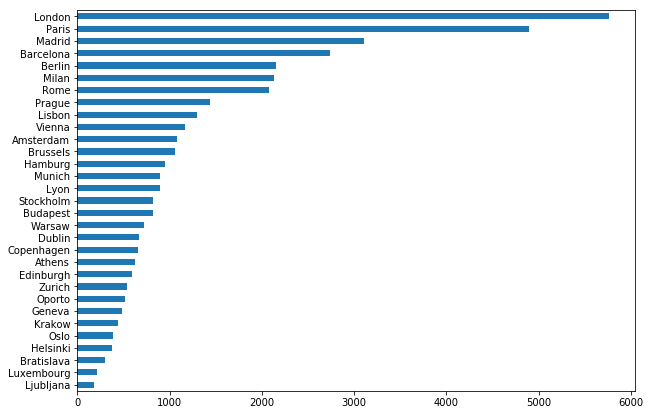

In [40]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

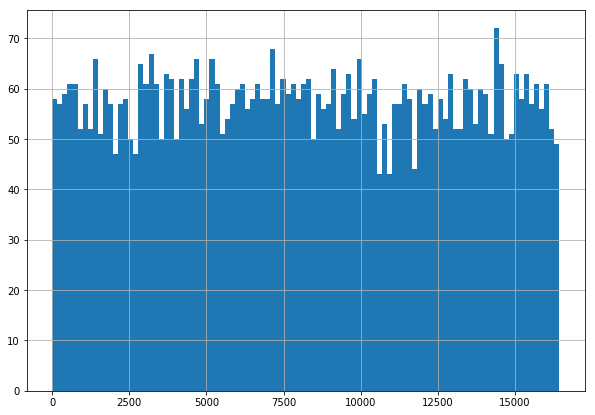

In [41]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

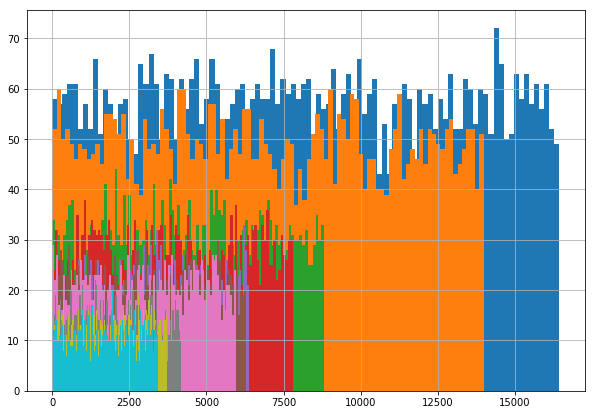

In [42]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

>Подумайте как из этого можно сделать признак для вашей модели. Я покажу вам пример, как визуализация помогает находить взаимосвязи. А далее действуйте без подсказок =) 


### Посмотрим распределение целевой переменной

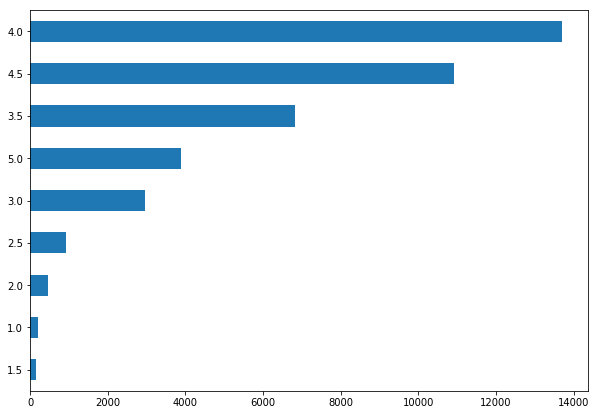

In [43]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

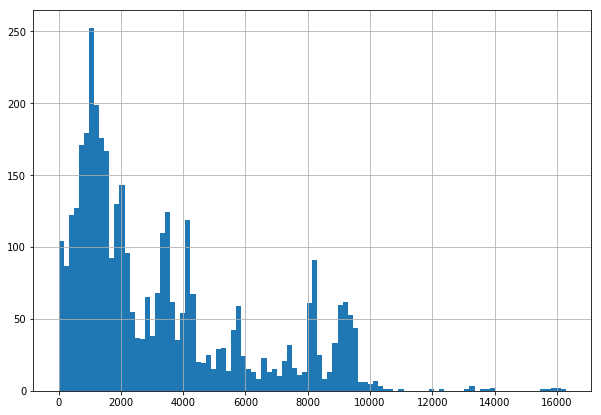

In [44]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

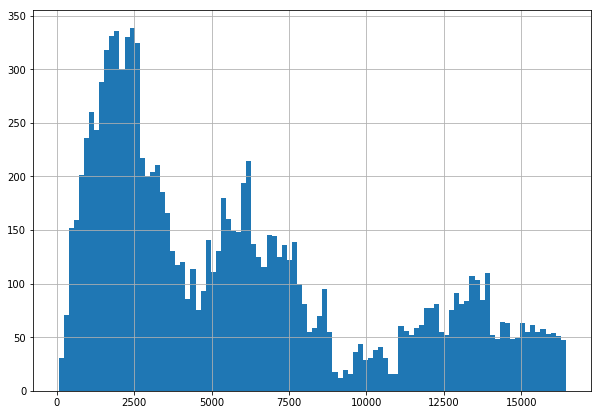

In [45]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

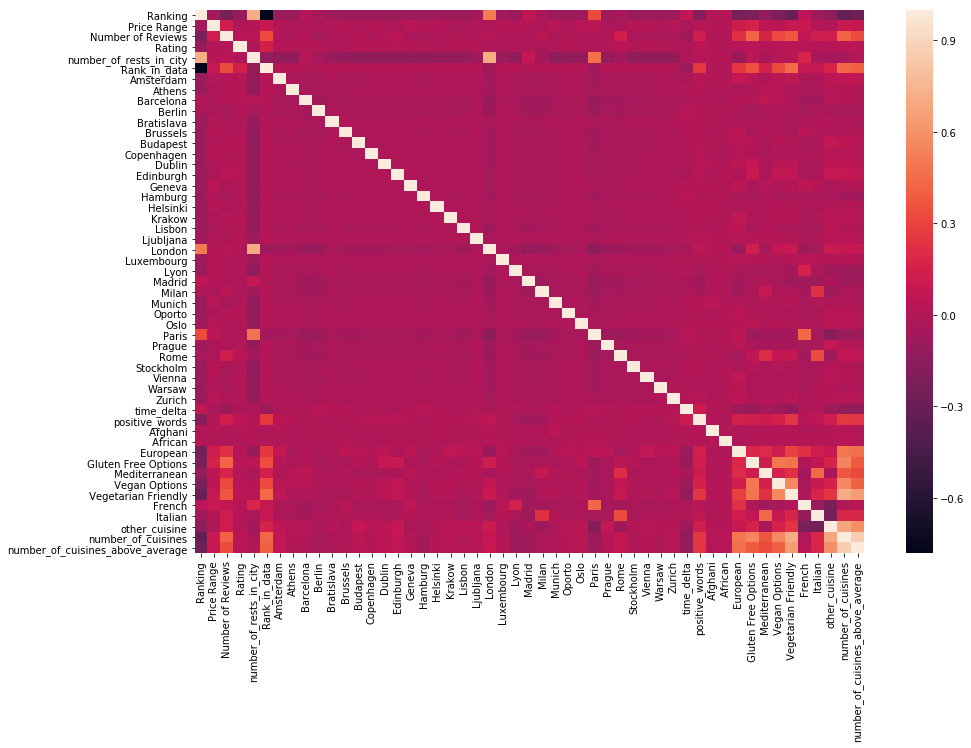

In [46]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

Вообще благодаря визуализации в этом датасете можно узнать много интересных фактов, например:
* где больше Пицерий в Мадриде или Лондоне?
* в каком городе кухня ресторанов более разнообразна?

придумайте свои вопрос и найдите на него ответ в данных)

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [47]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [48]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    #df_output.drop(['Restaurant_id','ID_TA',], axis = 1, inplace=True)
    
    
    # ################### 2. NAN ############################################################## 
    # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд...
    df_output['Number of Reviews'].fillna(0, inplace=True)
    # тут ваш код по обработке NAN
    # ....
    
    
    # ################### 3. Encoding ############################################################## 
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
    #df_output = pd.get_dummies(df_output, columns=[ 'City'])
    # тут ваш код не Encoding фитчей
    # ....
    
    

   

    #добавляем колонку кол-во ресторанов в каждом городе

    cities = df_output.City.value_counts()
    df_output.loc[:, 'number_of_rests_in_city'] = 0

    for i in range(0, len(df_output.City)):
        df_output.number_of_rests_in_city[i] = cities[df_output.City[i]]


#     # добавить колонку кол-во ресторанов минус рейтинг в городе
    df_output['Rank_in_data'] = df_output.number_of_rests_in_city-df_output.Ranking

#     # добавляем дамми переменные разных городов
#     #data = pd.get_dummies(data, columns=[ 'City',], dummy_na=True)
#     # добавляем дамми переменные разных городов
    City_names = df_output.City.str.get_dummies()
    df_output = df_output.join(City_names)
    
#     # ranking
    df_output.Ranking = df_output.Ranking.astype(int)
    
    
#     # Ваша обработка 'Price Range'
    
#     # меняем символьное обозначение на буквенное
    df_output['Price Range'] = df_output['Price Range'].replace('$$$$', 3)
    df_output['Price Range'] = df_output['Price Range'].replace('$$ - $$$', 2)
    df_output['Price Range'] = df_output['Price Range'].replace('$', 1)

    

#     # заполняем пропуски рандомно, сохраняя исходное соотношение между значениями
    

    mylist = [3, 1, 2]

    w_1 = df_output['Price Range'][df_output['Price Range'] == 3].count()/len(df_output['Price Range'])
    w_2 = df_output['Price Range'][df_output['Price Range'] == 1].count()/len(df_output['Price Range'])
    w_3 = df_output['Price Range'][df_output['Price Range'] == 2].count()/len(df_output['Price Range'])


    random_prices = random.choices(mylist, weights = [w_1, w_2, w_3], k = df_output['Price Range'].isnull().sum())

    j=0
    for i in range(len(df_output['Price Range'])):
        if pd.isna(df_output['Price Range'][i]) == True:
            df_output['Price Range'][i]=random_prices[j]
            j+=1

    df_output['Price Range'] = df_output['Price Range'].astype(int)
    
#     #Number of Reviews
    
    df_output['Number of Reviews']=df_output['Number of Reviews'].astype(int)
    
    
#     # reviews
    
    # выделяем из колонки Reviews даты и записываем их в отдельные колонки
    dates = []
    for line in df_output.Reviews:
        dates.append(re.findall(r'\d{2}/\d{2}/\d{4}', str(line)))

    date_1 = []
    date_2 = []
    value=''
    for value in dates:
        if value == []:
            date_1.append(datetime.date.today())
            date_2.append(datetime.date.today())
        elif len(value) == 1:
            date_1.append(datetime.datetime.strptime(value[0], '%m/%d/%Y').date())
            date_2.append(datetime.datetime.strptime(value[0], '%m/%d/%Y').date())
        else:
            date_1.append(datetime.datetime.strptime(value[0], '%m/%d/%Y').date())
            date_2.append(datetime.datetime.strptime(value[1], '%m/%d/%Y').date())

    df_output['date_1'] = date_1
    df_output['date_2'] = date_2

    # добавляем колонку с разницей дат
    time_delta = df_output['date_1']-df_output['date_2']
    df_output['time_delta'] = time_delta.dt.days

    
    #получаем список комментрариев отдельно от дат, чистим комментарии, оставляем тлько значимые слова



    sw = stopwords.words('english')

    #The function
    def clean_text(text):
        text = text.lower()
        text = re.sub('@', '', text)
        text = re.sub('\[.*?\]', '', text)
        text = re.sub('https?://\S+|www\.\S+', '', text)
        text = re.sub('<.*?>+', '', text)
        text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
        text = re.sub('\n', '', text)
        text = re.sub('\w*\d\w*', '', text)
        text = re.sub(r"[^a-zA-Z ]+", "", text)

        #Tokenize the data
        text = nltk.word_tokenize(text)
        #Remove stopwords
        text = [w for w in text if w not in sw]
        return text


    #df.Reviews = df.Reviews.apply(lambda x: df.Reviews[i].split("], [")[0]  )
    df_output.Reviews = list(map(lambda  x: str(x).split("], [")[0],df_output.Reviews))
    df_output.Reviews = df_output.Reviews.apply(lambda x: clean_text(x))


    
    # отбираем вручную положительные слова
    positive_words = ['good', 'great', 'nice', 'best', 'excellent', 'delicious', 'friendly', 'lovely', 'amazing',
                      'tasty', 'fantastic', 'perfect', 'wonderful', 'cozy', 'pleasant', 'love', 'super', 'surprise', 
                      'beautiful']

    #  доблвяем колонку о количестве позитивных слов в комментарии
    df_output.loc[:, 'positive_words'] = 0
    for i in range(0, len(df_output.Reviews)):
        k = 0
        for word in df_output.Reviews[i]:
            if word in positive_words:
                k += 1
        df_output.positive_words[i] = k
        
        
        
#     #Cuisine Style
#         # удаляем лишние символы
     # Кухни, которые встречаются меньше пяти раз отноми к категории other
    df_output['Cuisine Style'] = df_output['Cuisine Style'].str.replace('[', '')
    df_output['Cuisine Style'] = df_output['Cuisine Style'].str.replace(']', '')
    df_output['Cuisine Style'] = df_output['Cuisine Style'].str.replace("' ", '')
    df_output['Cuisine Style'] = df_output['Cuisine Style'].str.replace("'", '')

#    # заполняем пропуски значением other_cuisine
    for i in range(len(df_output['Cuisine Style'])):
        if pd.isna(df_output['Cuisine Style'][i]) == True:
            df_output['Cuisine Style'][i] = 'other_cuisine'
        
#         # добавляем дамми переменные разных кухонь
    cuisine_types = df_output['Cuisine Style'].str.get_dummies(sep=',')
    df_output = df_output.join(cuisine_types)

    display(df_output.columns[:100])
    # Кухни, которые встречаются меньше 3000 раз отноми к категории other_cuisine
    columns = []

    for column in df_output.columns[47:]:
        if df_output[column].sum() < 3000:
            df_output.other_cuisine = df_output.other_cuisine + df_output[column]
            columns.append(column)

    df_output = df_output.drop(df_output[columns], axis=1)
    
    # добавляем новый признак - количество кухонь в ресторане
    df_output.loc[:, 'number_of_cuisines'] = 0

    cuisine_quantity = []
    for value in df_output['Cuisine Style']:

        cuisine_quantity.append(len(value.split(', ')))

    df_output.number_of_cuisines = df_output.number_of_cuisines + cuisine_quantity

    # среднее количество кухонь в одном ресторане
    cuisines_average = (cuisine_types.sum().sum() +
                        df_output['Cuisine Style'].isnull().sum())/len(cuisine_types)



    # добавляем новый признак - количество кухонь в ресторане выше среднего
    df_output.loc[:, 'number_of_cuisines_above_average'] = 0

    above_average = []
    for value in df_output.number_of_cuisines:
        if value > cuisines_average:
            above_average.append(1)
        else:
            above_average.append(0)

    df_output.number_of_cuisines_above_average = df_output.number_of_cuisines_above_average + above_average
        
#     # ################### 4. Feature Engineering ####################################################
#     # тут ваш код не генерацию новых фитчей
#     # ....
    
    
#     # ################### 5. Clean #################################################### 
#     # убираем признаки которые еще не успели обработать, 
#     # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    
    df_output.drop(['Restaurant_id','ID_TA','Cuisine Style', 'Reviews', 'URL_TA', 'date_1', 'date_2'], axis = 1, inplace=True)
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis = 1, inplace=True)
    
    display(df_output.columns[:100])
    
    return df_output

>По хорошему, можно было бы перевести эту большую функцию в класс и разбить на подфункции (согласно ООП). 

#### Запускаем и проверяем что получилось

In [49]:
df_preproc = preproc_data(data)
df_preproc.sample(10)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:172: SettingWithCopyWarning: 
A value is trying to be

Index(['Restaurant_id', 'City', 'Cuisine Style', 'Ranking', 'Price Range',
       'Number of Reviews', 'Reviews', 'URL_TA', 'ID_TA', 'sample', 'Rating',
       'number_of_rests_in_city', 'Rank_in_data', 'Amsterdam', 'Athens',
       'Barcelona', 'Berlin', 'Bratislava', 'Brussels', 'Budapest',
       'Copenhagen', 'Dublin', 'Edinburgh', 'Geneva', 'Hamburg', 'Helsinki',
       'Krakow', 'Lisbon', 'Ljubljana', 'London', 'Luxembourg', 'Lyon',
       'Madrid', 'Milan', 'Munich', 'Oporto', 'Oslo', 'Paris', 'Prague',
       'Rome', 'Stockholm', 'Vienna', 'Warsaw', 'Zurich', 'date_1', 'date_2',
       'time_delta', 'positive_words', ' Afghani', ' African', ' Albanian',
       ' American', ' Arabic', ' Argentinean', ' Armenian', ' Asian',
       ' Australian', ' Austrian', ' Azerbaijani', ' Balti', ' Bangladeshi',
       ' Bar', ' Barbecue', ' Belgian', ' Brazilian', ' Brew Pub', ' British',
       ' Burmese', ' Cafe', ' Cajun & Creole', ' Cambodian', ' Canadian',
       ' Caribbean', ' Caucasi

Index(['Ranking', 'Price Range', 'Number of Reviews', 'sample', 'Rating',
       'number_of_rests_in_city', 'Rank_in_data', 'Amsterdam', 'Athens',
       'Barcelona', 'Berlin', 'Bratislava', 'Brussels', 'Budapest',
       'Copenhagen', 'Dublin', 'Edinburgh', 'Geneva', 'Hamburg', 'Helsinki',
       'Krakow', 'Lisbon', 'Ljubljana', 'London', 'Luxembourg', 'Lyon',
       'Madrid', 'Milan', 'Munich', 'Oporto', 'Oslo', 'Paris', 'Prague',
       'Rome', 'Stockholm', 'Vienna', 'Warsaw', 'Zurich', 'time_delta',
       'positive_words', ' European', ' Gluten Free Options', ' Mediterranean',
       ' Vegan Options', ' Vegetarian Friendly', 'French', 'Italian',
       'other_cuisine', 'number_of_cuisines',
       'number_of_cuisines_above_average'],
      dtype='object')

,Ranking,Price Range,Number of Reviews,sample,Rating,number_of_rests_in_city,Rank_in_data,Amsterdam,Athens,Barcelona,...,European,Gluten Free Options,Mediterranean,Vegan Options,Vegetarian Friendly,French,Italian,other_cuisine,number_of_cuisines,number_of_cuisines_above_average
4489,376,2,41,0,0.0,1186,810.0,0,0,0,...,0,0,0,1,1,0,0,3,5,1
28358,517,2,283,1,4.5,1816,1299.0,0,0,0,...,0,0,0,0,1,0,0,1,2,0
30252,3822,2,66,1,4.0,2589,-1233.0,0,0,0,...,0,0,1,0,1,0,1,0,3,1
46407,4810,1,7,1,5.0,2589,-2221.0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
20795,556,2,31,1,4.5,776,220.0,0,1,0,...,0,0,1,0,1,0,0,1,3,1
23012,2140,2,3,1,3.0,1126,-1014.0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
18930,13305,2,86,1,3.0,7193,-6112.0,0,0,0,...,0,0,0,0,0,0,0,3,3,1
47475,8218,2,16,1,2.5,3813,-4405.0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
31533,2652,2,7,1,4.0,1816,-836.0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
41472,7749,1,49,1,3.5,6108,-1641.0,0,0,0,...,0,0,0,0,0,0,1,1,2,0


In [50]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 50 columns):
Ranking                             50000 non-null int64
Price Range                         50000 non-null int64
Number of Reviews                   50000 non-null int64
sample                              50000 non-null int64
Rating                              50000 non-null float64
number_of_rests_in_city             50000 non-null int64
Rank_in_data                        50000 non-null float64
Amsterdam                           50000 non-null int64
Athens                              50000 non-null int64
Barcelona                           50000 non-null int64
Berlin                              50000 non-null int64
Bratislava                          50000 non-null int64
Brussels                            50000 non-null int64
Budapest                            50000 non-null int64
Copenhagen                          50000 non-null int64
Dublin                          

In [51]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [52]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [53]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 49), (40000, 49), (40000, 48), (32000, 48), (8000, 48))

# Model 
Сам ML

In [54]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [55]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [56]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [57]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.205463125


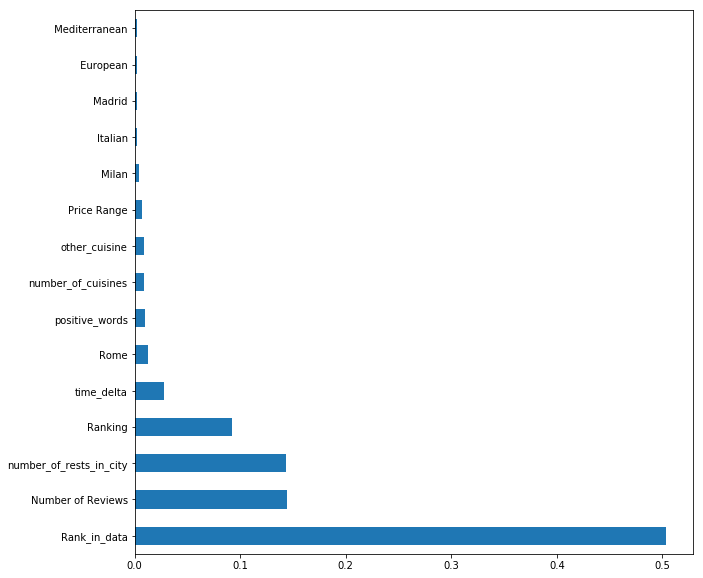

In [58]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [59]:
test_data.sample(10)

,Ranking,Price Range,Number of Reviews,Rating,number_of_rests_in_city,Rank_in_data,Amsterdam,Athens,Barcelona,Berlin,...,European,Gluten Free Options,Mediterranean,Vegan Options,Vegetarian Friendly,French,Italian,other_cuisine,number_of_cuisines,number_of_cuisines_above_average
2433,211,2,109,0.0,819,608.0,0,0,0,0,...,1,0,0,0,0,0,0,3,4,1
868,3006,2,0,0.0,1314,-1692.0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
8650,1187,2,37,0.0,836,-351.0,0,0,0,0,...,0,0,0,0,0,0,0,2,2,0
6752,401,2,88,0.0,590,189.0,0,0,0,0,...,1,0,1,0,1,0,1,0,4,1
2297,2745,1,15,0.0,1816,-929.0,0,0,0,0,...,0,0,0,0,0,0,0,2,2,0
5063,591,2,282,0.0,1314,723.0,0,0,0,0,...,0,1,0,1,1,0,0,1,4,1
6828,2134,2,4,0.0,1443,-691.0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
9711,631,1,18,0.0,590,-41.0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
677,8718,2,52,0.0,3813,-4905.0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
3367,5768,2,0,0.0,2589,-3179.0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0


In [60]:
test_data = test_data.drop(['Rating'], axis=1)

In [61]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [62]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [63]:
predict_submission

array([2.995, 4.31 , 4.395, ..., 3.01 , 4.495, 4.31 ])

In [64]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,2.995
1,id_1,4.310
2,id_2,4.395
3,id_3,4.375
4,id_4,4.405
5,id_5,4.440
6,id_6,2.495
7,id_7,2.770
8,id_8,4.135
9,id_9,4.725


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
